In [ ]:
!pip install plotly
!pip install scikit-learn==1.2.1
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps
!pip install scanpy

In [1]:
%load_ext autoreload

In [2]:
from os.path import join
import pickle

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
import scanpy as sc
from scipy.sparse import csr_matrix

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_simple_norm_parquet'
CKPT_PATH = '/mnt/dssfs02/tb_logs/cellnet_simple/default/version_5/checkpoints/val_f1_macro_epoch=43_val_f1_macro=0.747.ckpt'

In [4]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
var = pd.read_parquet(join(DATA_PATH, 'var.parquet'))

# Load and preprocess data

In [5]:
adata = sc.read_h5ad('/mnt/dssfs02/local.h5ad')
# subset only to cell types which the model knows
adata = adata[
    adata.obs.cell_type.isin(
        [cell_type for cell_type in adata.obs.cell_type.unique().tolist() 
         if cell_type in cell_type_mapping.label.tolist()]
    )
].copy()

adata

AnnData object with n_obs × n_vars = 35699 × 24185
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'schema_version', 'seurat_clusters_colors', 'title'
    obsm: 'X_pca', 'X_umap'

In [6]:
%autoreload
from cellnet.utils.data_loading import streamline_count_matrix, sf_normalize

In [7]:
X = streamline_count_matrix(adata.raw.X, gene_names_raw=adata.var.index, gene_names_model=var.index)
obs = pd.DataFrame({
    'idx': np.arange(len(adata)),
    'cell_type': adata.obs.cell_type.replace({v: k for k, v in cell_type_mapping.label.to_dict().items()}).to_numpy()
})
y_true = obs.cell_type.to_numpy()

In [8]:
# normalize data 
# zero centering is NOT applied here -> this is done when running inference step
preproc_pipeline = pickle.load(open(join(DATA_PATH, 'norm/preproc_pipeline/preproc_pipeline.pickle'), 'rb'))
X = csr_matrix(preproc_pipeline.transform(X))

# Load model

In [9]:
%autoreload
from cellnet.utils.data_loading import dataloader_factory

In [10]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.model = TabnetClassifier.load_from_checkpoint(CKPT_PATH, **estim.get_fixed_model_params('tabnet'))
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Classification performance

In [11]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from utils import correct_labels

In [12]:
probas = estim.predict(dataloader_factory(X, obs, batch_size=2048))
y_pred = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


In [13]:
assert y_pred.shape[0] == y_true.shape[0]

#### Overall performance

In [14]:
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

In [15]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, labels=np.unique(y_true), output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
micro avg,0.906194,0.885151,0.895549,35699.0
macro avg,0.932380,0.850807,0.878612,35699.0
weighted avg,0.915766,0.885151,0.890196,35699.0


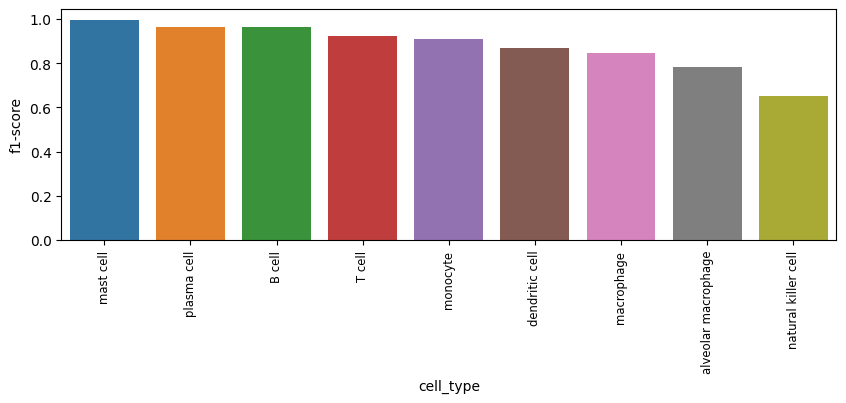

In [16]:
plt.rcParams['figure.figsize'] = (10, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_tick_params(labelsize='small');

# Visualize predictions

In [17]:
import anndata
import scanpy as sc

## predictions vs true labels

Plot TSNE embedding (based on 64 PCA components of the input features) and super-impose true labels and predicted labels

In [18]:
adata = anndata.AnnData(
    X=X, 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten()
    })
)
sc.pp.pca(adata, n_comps=64)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
# sc.pp.subsample(adata, n_obs=200_000)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


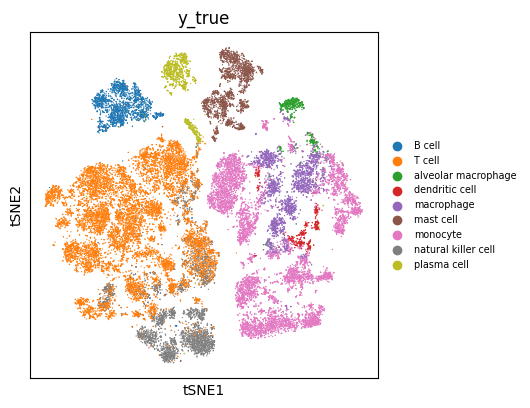

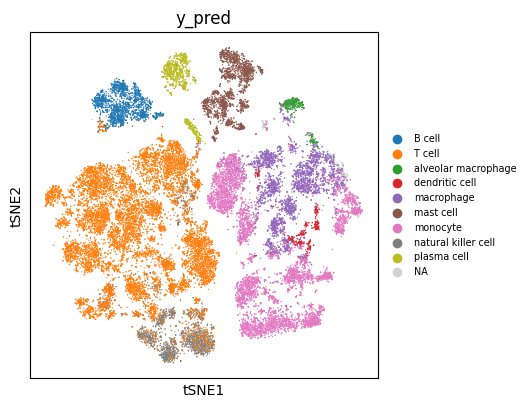

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


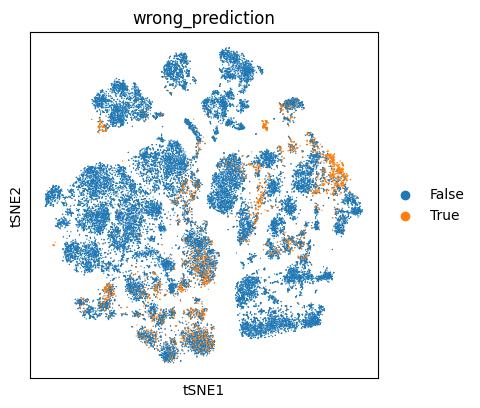

In [20]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata, color='wrong_prediction')

## Visualize learned features

Plot TSNE embedding (based on last layer of trained neural network) and super-impose true labels and predicted labels

In [21]:
# get feature embedding
estim.model.predict_bottleneck = True
x_emb = estim.predict(dataloader_factory(X, obs, batch_size=2048))
estim.model.predict_bottleneck = False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


In [22]:
adata_emb = anndata.AnnData(
    X=x_emb, 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten()
    })
)
adata_emb.obs['wrong_prediction'] = (adata.obs.y_true.astype(str) != adata.obs.y_pred.astype(str)).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
# sc.pp.subsample(adata_emb, n_obs=200_000)
# reduce to 64 dim before computing TSNE embedding
sc.pp.pca(adata_emb, n_comps=64)
sc.pp.neighbors(adata_emb)
sc.tl.tsne(adata_emb)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


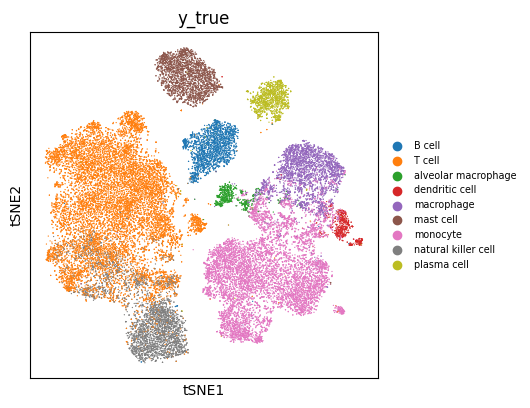

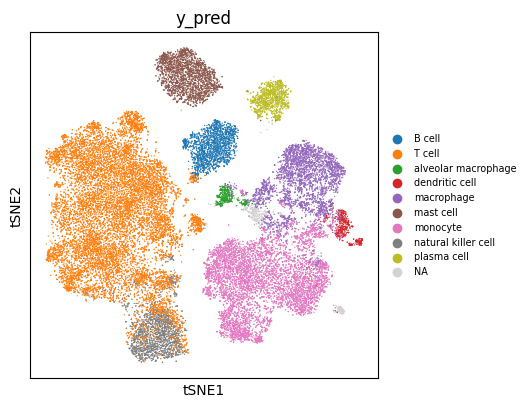

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


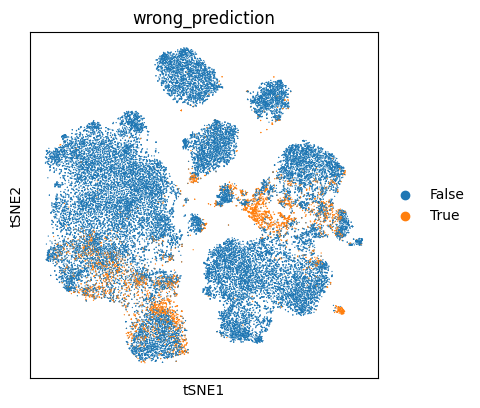

In [24]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata_emb.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata_emb.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
# adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.cat.remove_unused_categories()
# adata_plot.obs['y_true'] = adata_plot.obs.y_true.cat.remove_unused_categories()

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_emb, color='wrong_prediction')